In [1]:
import os, sys

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import keras.layers

#import neuron
#import voxelmorph as vxm


Using TensorFlow backend.


In [2]:
sys.path.append('/home/lbarras/voxelmorph/ext/pynd-lib/')
sys.path.append('/home/lbarras/voxelmorph/ext/pytools-lib/')
sys.path.append('/home/lbarras/voxelmorph/ext/neuron/')
sys.path.append('/home/lbarras/voxelmorph/src')
sys.path.append('/home/lbarras/voxelmorph/')
import src as vxm
import neuron

In [3]:
from keras.datasets import mnist

In [4]:
# load the data. 
# `mnist.load_data()` already splits our data into train and test.  
# (x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

# unfortunately the above seems to fail on the keras kernel
# so we will load it from a pre-downloaded mnist numpy file
mnist_file = '/home/lbarras/mnist.npz'
x_train_load = np.load(mnist_file)['x_train']
y_train_load = np.load(mnist_file)['y_train']
x_test_load = np.load(mnist_file)['x_test']
y_test_load = np.load(mnist_file)['y_test']

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==5, ...]
y_train = y_train_load[y_train_load==5]
x_test = x_test_load[y_test_load==5, ...]
y_test = y_test_load[y_test_load==5]

# let's get some shapes to understand what we loaded.
print('shape of x_train: ', x_train.shape)
print('shape of y_train: ', y_train.shape)

shape of x_train:  (5421, 28, 28)
shape of y_train:  (5421,)


In [5]:
nb_val = 1000 # keep 10,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

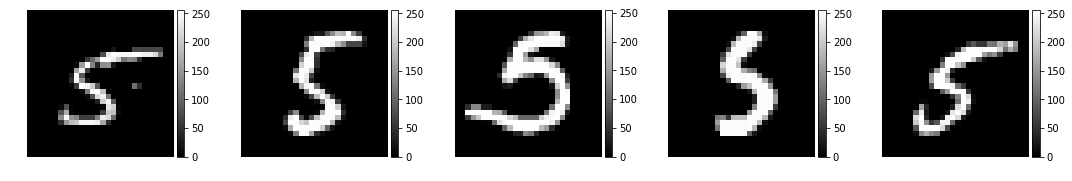

In [6]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [7]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


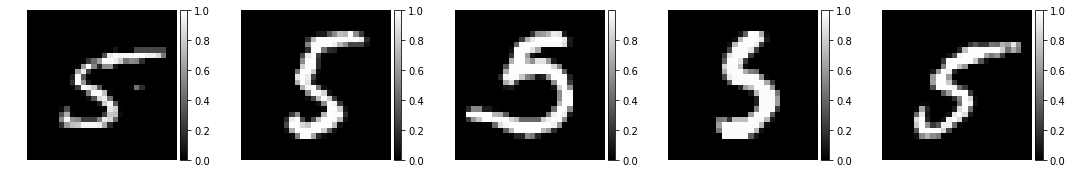

In [8]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [9]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


In [10]:
ndims = 2
vol_shape = x_train.shape[1:]
nb_enc_features = [32, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16]

In [11]:
# first, let's get a unet (before the final layer)
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);

In [12]:
# inputs
print('numer of inputs', len(unet.inputs))
moving_input_tensor = unet.inputs[0]
fixed_input_tensor = unet.inputs[1]
    
# output
print('output:', unet.output)

numer of inputs 2
output: Tensor("leaky_re_lu_10/LeakyRelu:0", shape=(?, 32, 32, 16), dtype=float32)


In [13]:
# transform the results into a flow field.
disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# check
print('displacement tensor:', disp_tensor)

displacement tensor: Tensor("disp/BiasAdd:0", shape=(?, 32, 32, 2), dtype=float32)


In [14]:
# a cool aspect of keras is that we can easily form new models via tensor pointers:
def_model = keras.models.Model(unet.inputs, disp_tensor)
# def_model will now *share layers* with the UNet -- if we change layer weights 
# in the UNet, they change in the def_model

In [15]:
spatial_transformer = neuron.layers.SpatialTransformer(name='spatial_transformer')

# warp the image
moved_image_tensor = spatial_transformer([moving_input_tensor, disp_tensor])

In [16]:
inputs = [moving_input_tensor, fixed_input_tensor]
outputs = [moved_image_tensor, disp_tensor]
vxm_model = keras.models.Model(inputs, outputs)

In [17]:
# losses. Keras recognizes the string 'mse' as mean squared error, so we don't have to code it
losses = ['mse', vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter.
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [18]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [19]:
def vxm_data_generator(x_data, batch_size=32):
    """
    generator that takes in data of size [N, H, W], and yields data for our vxm model
    
    Note that we need to provide numpy data for each input, and each output
    
    inputs:  moving_image [bs, H, W, 1], fixed_image [bs, H, W, 1]
    outputs: moved_image  [bs, H, W, 1], zeros [bs, H, W, 2]
    """
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation. We'll explain this below.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs
        # inputs need to be of the size [batch_size, H, W, number_features]
        #   number_features at input is 1 for us
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # outputs
        # we need to prepare the "true" moved image.  
        # Of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield inputs, outputs

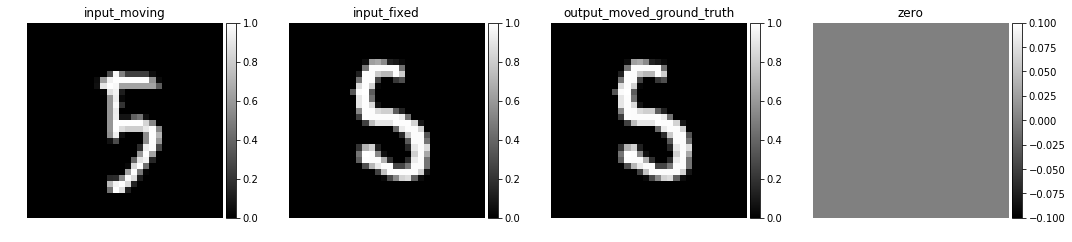

In [20]:
# let's test it
train_generator = vxm_data_generator(x_train)
input_sample, output_sample = next(train_generator)

# visualize
slices_2d = [f[0,...,0] for f in input_sample + output_sample]
titles = ['input_moving', 'input_fixed', 'output_moved_ground_truth', 'zero']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

In [21]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
 - 12s - loss: 0.0479 - spatial_transformer_loss: 0.0431 - disp_loss: 0.0965
Epoch 2/10
 - 9s - loss: 0.0266 - spatial_transformer_loss: 0.0214 - disp_loss: 0.1044
Epoch 3/10
 - 9s - loss: 0.0212 - spatial_transformer_loss: 0.0163 - disp_loss: 0.0992
Epoch 4/10
 - 9s - loss: 0.0187 - spatial_transformer_loss: 0.0139 - disp_loss: 0.0946
Epoch 5/10
 - 9s - loss: 0.0167 - spatial_transformer_loss: 0.0121 - disp_loss: 0.0921
Epoch 6/10
 - 9s - loss: 0.0156 - spatial_transformer_loss: 0.0111 - disp_loss: 0.0895
Epoch 7/10
 - 9s - loss: 0.0152 - spatial_transformer_loss: 0.0107 - disp_loss: 0.0894
Epoch 8/10
 - 9s - loss: 0.0141 - spatial_transformer_loss: 0.0098 - disp_loss: 0.0875
Epoch 9/10
 - 9s - loss: 0.0136 - spatial_transformer_loss: 0.0092 - disp_loss: 0.0866
Epoch 10/10
 - 9s - loss: 0.0133 - spatial_transformer_loss: 0.0091 - disp_loss: 0.0850


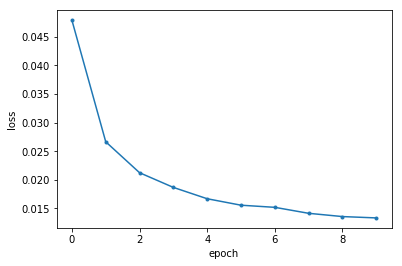

In [22]:
# as with other imports, this import should be at the top, or use notebook matplotlib magic
# we keep it here to be explicit why we need it
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    """
    Quick function to plot the history 
    """
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [23]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [24]:
val_pred = vxm_model.predict(val_input)

In [25]:
%timeit vxm_model.predict(val_input)

5.01 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


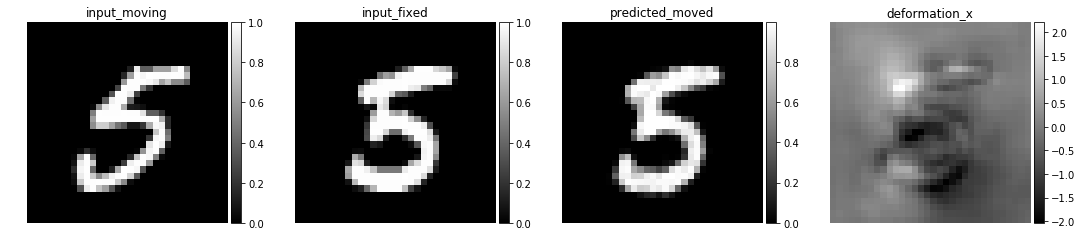

In [26]:
# visualize
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

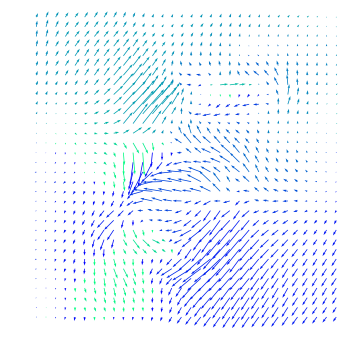

In [27]:
neuron.plot.flow([val_pred[1].squeeze()], width=5);

In [28]:
# extract only instances of the digit 5
x_sevens = x_train_load[y_train_load==7, ...].astype('float')/255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

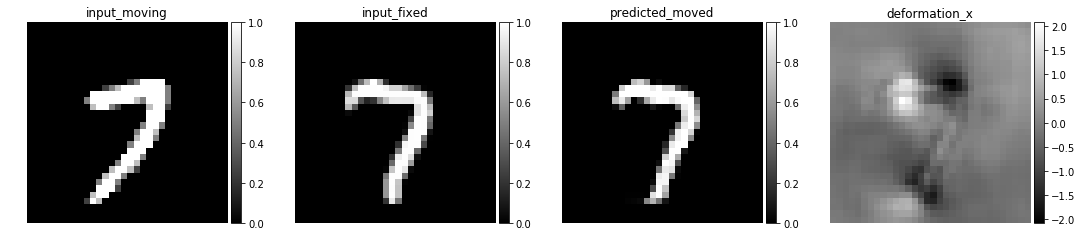

In [29]:
# visualize
slices_2d = [f[0,...,0] for f in seven_sample + seven_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

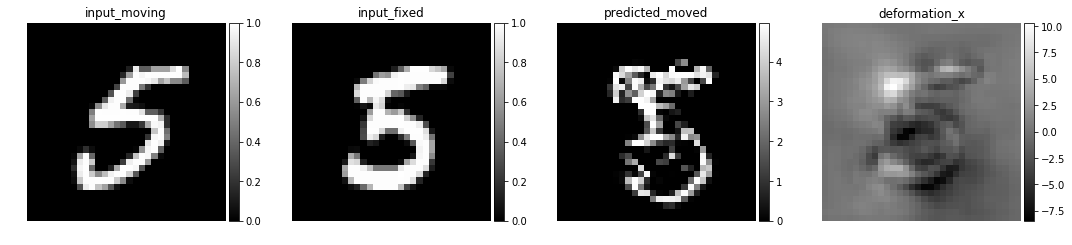

In [30]:
factor = 5
val_pred = vxm_model.predict([f*factor for f in val_input])

# visualizeb
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

In [31]:
# we've prepared the data in the following files
# prepared as N x H x W
core_path = '/home/lbarras/mri-2d/'
x_train = np.load(os.path.join(core_path, 'train_vols.npy'))
x_val = np.load(os.path.join(core_path, 'validate_vols.npy'))
# x_test = np.load(os.path.join(core_path, 'test_vols.npy'))

vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


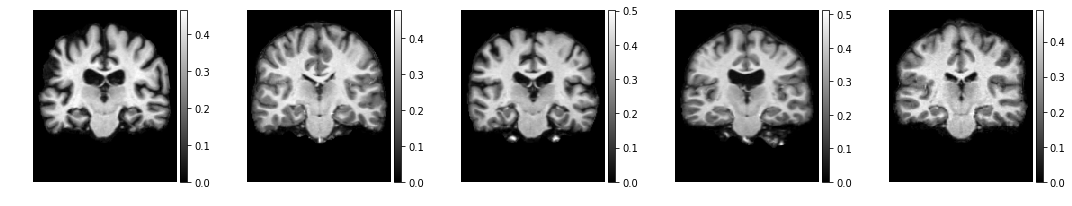

In [32]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [33]:
# unet
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);
disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# spatial transfomer
spatial_transformer = neuron.layers.SpatialTransformer(name='image_warping')
moved_image_tensor = spatial_transformer([unet.inputs[0], disp_tensor])

# final model
vxm_model = keras.models.Model(unet.inputs, [moved_image_tensor, disp_tensor])

In [34]:
# losses. Keras recognizes the string 'mse' as mean squared error, so we don't have to code it
losses = ['mse', vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter.
lambda_param = 0.01
loss_weights = [1, lambda_param]

In [35]:
vxm_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

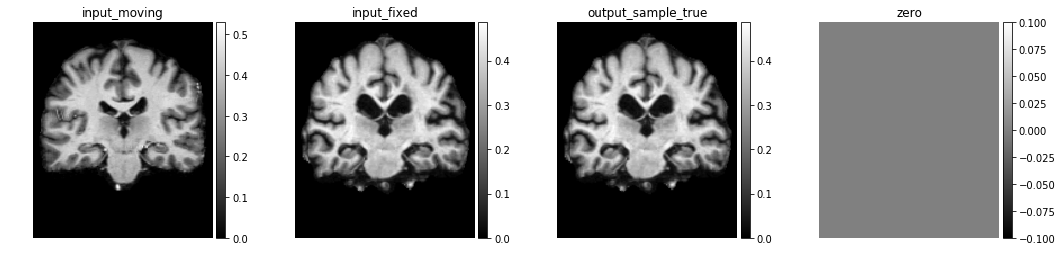

In [36]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
input_sample, output_sample = next(train_generator)

# visualize
slices_2d = [f[0,...,0] for f in input_sample + output_sample]
titles = ['input_moving', 'input_fixed', 'output_sample_true', 'zero']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

In [37]:
nb_epochs = 10
steps_per_epoch = 10

In [38]:
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
 - 3s - loss: 0.0069 - image_warping_loss: 0.0069 - disp_loss: 0.0011
Epoch 2/10
 - 0s - loss: 0.0071 - image_warping_loss: 0.0070 - disp_loss: 0.0011
Epoch 3/10
 - 0s - loss: 0.0064 - image_warping_loss: 0.0064 - disp_loss: 0.0012
Epoch 4/10
 - 0s - loss: 0.0064 - image_warping_loss: 0.0064 - disp_loss: 0.0015
Epoch 5/10
 - 1s - loss: 0.0066 - image_warping_loss: 0.0065 - disp_loss: 0.0023
Epoch 6/10
 - 0s - loss: 0.0063 - image_warping_loss: 0.0063 - disp_loss: 0.0038
Epoch 7/10
 - 0s - loss: 0.0064 - image_warping_loss: 0.0063 - disp_loss: 0.0053
Epoch 8/10
 - 0s - loss: 0.0067 - image_warping_loss: 0.0067 - disp_loss: 0.0086
Epoch 9/10
 - 0s - loss: 0.0060 - image_warping_loss: 0.0059 - disp_loss: 0.0122
Epoch 10/10
 - 0s - loss: 0.0053 - image_warping_loss: 0.0051 - disp_loss: 0.0189


In [39]:
# for the purpose of the tutorial we ran very few epochs.  
# Here we load a model that was run for 10 epochs and 100 steps per epochs
vxm_model.load_weights('/home/lbarras/learn2reg-unsupervised-models/brain_2d_shortrun.h5')

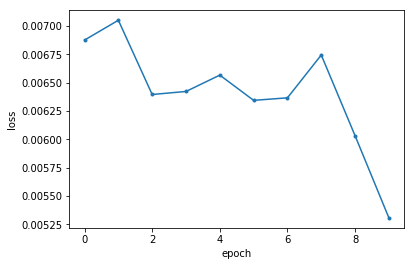

In [40]:
# as before, let's visualize what happened
plot_history(hist)

In [41]:
val_generator = vxm_data_generator(x_val, batch_size = 1)

In [42]:
val_input, _ = next(val_generator)

In [43]:

val_pred = vxm_model.predict(val_input)

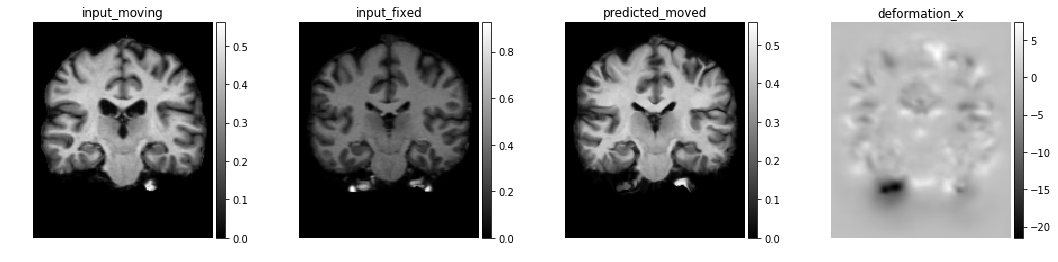

In [44]:
# visualize
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

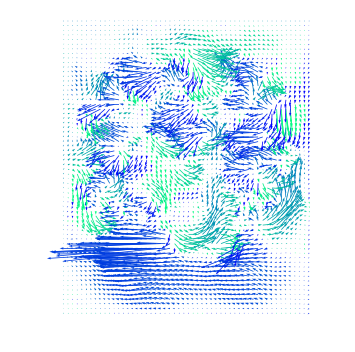

In [45]:
flow = val_pred[1].squeeze()[::3,::3]
neuron.plot.flow([flow], width=5);

In [46]:
vxm_model.save_weights('brain_2d_shortrun.h5')

In [47]:
vxm_model.load_weights('/home/lbarras/learn2reg-unsupervised-models/brain_2d_shortrun.h5')
our_val_pred = vxm_model.predict(val_input)

vxm_model.load_weights('/home/lbarras/learn2reg-unsupervised-models/brain_2d_mseonly.h5')
mse_val_pred = vxm_model.predict(val_input)

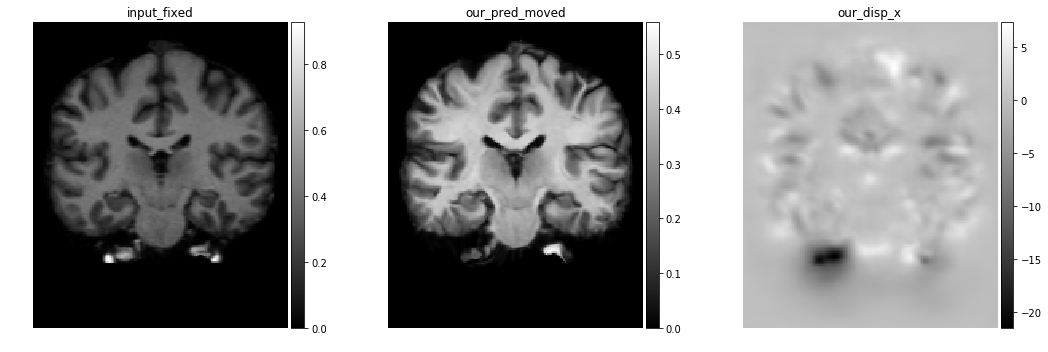

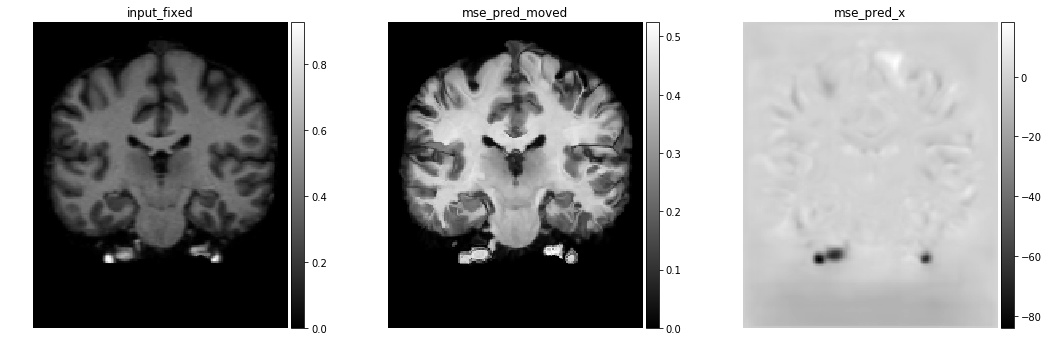

In [48]:
# visualize both models
slices_2d = [f[0,...,0] for f in [val_input[1]] + our_val_pred ]
titles = ['input_fixed', 'our_pred_moved', 'our_disp_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize both models
slices_2d = [f[0,...,0] for f in [val_input[1]] + mse_val_pred]
titles = ['input_fixed', 'mse_pred_moved', 'mse_pred_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

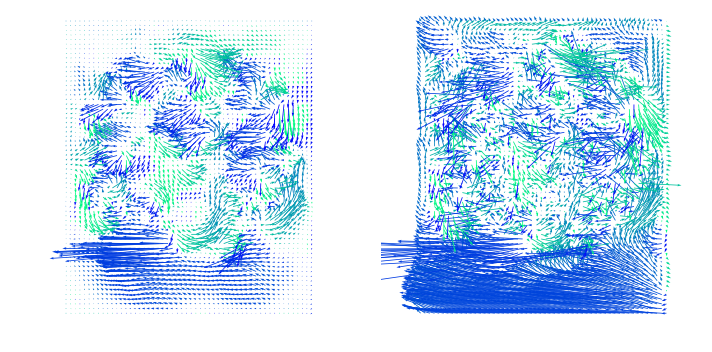

In [49]:
neuron.plot.flow([f[1].squeeze()[::3,::3] for f in [our_val_pred, mse_val_pred]], width=10);

In [50]:
# our data will be of shape 160 x 192 x 224
vol_shape = [160, 192, 224]
ndims = 3

In [51]:
nb_enc_features = [16, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16, 16]

In [52]:
# unet
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);
disp_tensor = keras.layers.Conv3D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# spatial transfomer
spatial_transformer = neuron.layers.SpatialTransformer(name='image_warping')
moved_image_tensor = spatial_transformer([unet.inputs[0], disp_tensor])

# final model
vxm_model = keras.models.Model(unet.inputs, [moved_image_tensor, disp_tensor])

In [53]:
val_volume_1 = np.load('/home/lbarras/learn2reg-mri-3d/subject_1_vol.npz')['vol_data']
seg_volume_1 = np.load('/home/lbarras/learn2reg-mri-3d/subject_1_seg.npz')['vol_data']
val_volume_2 = np.load('/home/lbarras/learn2reg-mri-3d/atlas_norm_3d.npz')['vol']
seg_volume_2 = np.load('/home/lbarras/learn2reg-mri-3d/atlas_norm_3d.npz')['seg']


val_input = [val_volume_1[np.newaxis, ..., np.newaxis], val_volume_2[np.newaxis, ..., np.newaxis]]

In [54]:
vxm_model.load_weights('/home/lbarras/learn2reg-unsupervised-models/cvpr2018_vm2_cc.h5')

In [55]:
val_pred = vxm_model.predict(val_input);

In [56]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

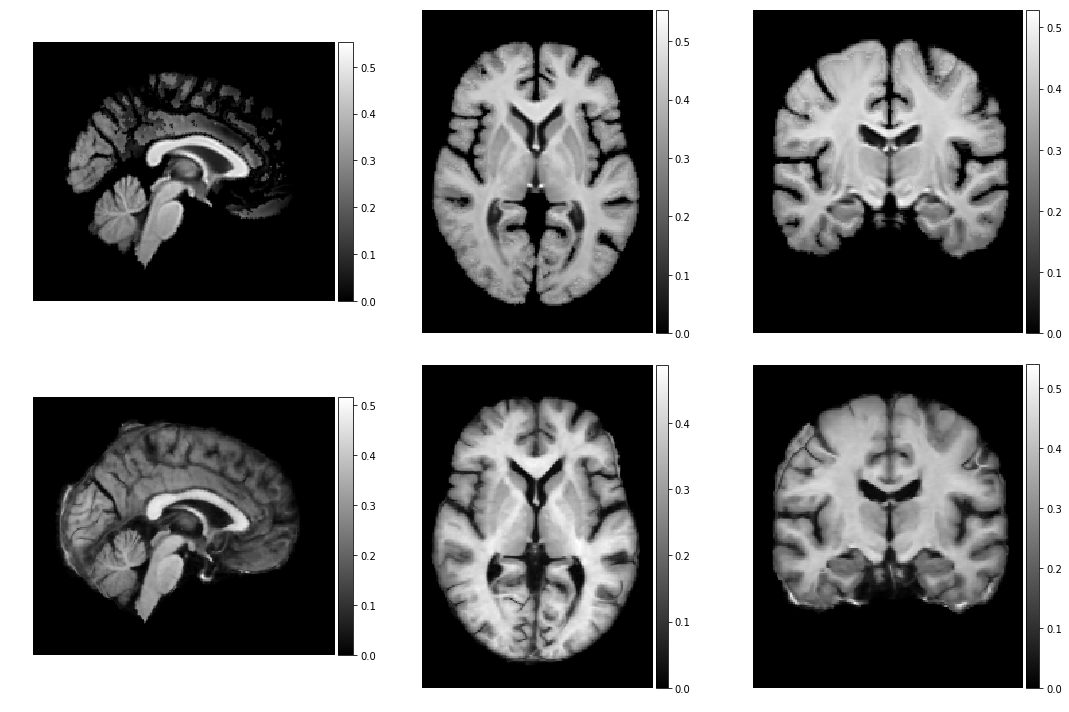

In [57]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
neuron.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

In [58]:
warp_model = vxm.networks.nn_trf(vol_shape)

In [59]:
warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

In [60]:
from pytools import plotting as pytools_plot
import matplotlib

[ccmap, scrambled_cmap] = pytools_plot.jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

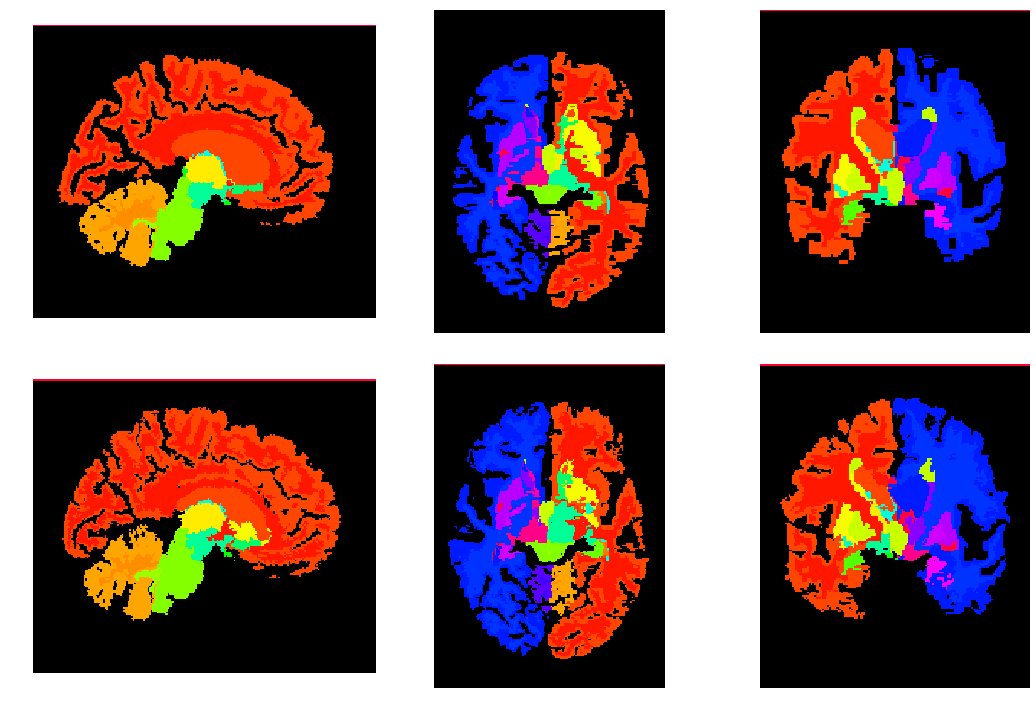

In [61]:
mid_slices_fixed = [np.take(seg_volume_1, vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
neuron.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

In [62]:
%timeit vxm_model.predict(val_input)

621 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
